## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
#import warnings
#warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [5]:
query = '''
from(bucket: "iot-demo")
  |> range(start: -12h, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["_field"] == "value")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  |> yield(name: "median")'''

In [6]:
#Query InfluxDB and return a Dataframe
df = client.query_api().query_data_frame(org=my_org, query=query)
df.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,median,0,2020-07-09 02:02:01.779664+00:00,2020-07-09 14:02:01.779664+00:00,value,humidity,RoomWeather,ubuntu,43.0,2020-07-09 02:10:00+00:00
1,median,0,2020-07-09 02:02:01.779664+00:00,2020-07-09 14:02:01.779664+00:00,value,humidity,RoomWeather,ubuntu,43.2,2020-07-09 02:20:00+00:00
2,median,0,2020-07-09 02:02:01.779664+00:00,2020-07-09 14:02:01.779664+00:00,value,humidity,RoomWeather,ubuntu,43.3,2020-07-09 02:30:00+00:00
3,median,0,2020-07-09 02:02:01.779664+00:00,2020-07-09 14:02:01.779664+00:00,value,humidity,RoomWeather,ubuntu,43.4,2020-07-09 02:40:00+00:00
4,median,0,2020-07-09 02:02:01.779664+00:00,2020-07-09 14:02:01.779664+00:00,value,humidity,RoomWeather,ubuntu,43.5,2020-07-09 02:50:00+00:00


In [7]:
df['temperature'] = df['_value']
#df['time'] = pd.to_datetime(df._time)
df['time'] = df['_time']
del df['result']
del df['table']
del df['_start']
del df['_stop']
del df['_field']
del df['_measurement']
del df['_value']
del df['_time']
del df['device']
del df['location']
#df.drop(columns=['result', 'table','_start','_stop', '_field', '_measurement', '_value', '_time', 'device', 'location'])
#df.set_index("time")
df.head()

,temperature,time
0,43.0,2020-07-09 02:10:00+00:00
1,43.2,2020-07-09 02:20:00+00:00
2,43.3,2020-07-09 02:30:00+00:00
3,43.4,2020-07-09 02:40:00+00:00
4,43.5,2020-07-09 02:50:00+00:00


In [8]:
len(df)

73

In [9]:
#divide in train e test? Serve??
#size = int(len(df)*0.8)
#df_train, df_test = df.iloc[:size], df.iloc[size:]

In [10]:
#creating returns
df['returns'] = df.temperature.pct_change(1)*100
df.head()

,temperature,time,returns
0,43.0,2020-07-09 02:10:00+00:00,NaN
1,43.2,2020-07-09 02:20:00+00:00,0.465116
2,43.3,2020-07-09 02:30:00+00:00,0.231481
3,43.4,2020-07-09 02:40:00+00:00,0.230947
4,43.5,2020-07-09 02:50:00+00:00,0.230415


## The LLR Test

In [11]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## ARIMA(1,1,1)

In [12]:
model_ar_1_i_1_ma_1 = ARIMA(df.temperature, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
results_ar_1_i_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.temperature   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  16.025
Method:                       css-mle   S.D. of innovations              0.193
Date:                Thu, 09 Jul 2020   AIC                            -24.050
Time:                        16:15:39   BIC                            -14.943
Sample:                             1   HQIC                           -20.424
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0184      0.037     -0.498      0.619      -0.091       0.054
ar.L1.D.temperature     0.0114      0.210      0.054      0.957      -0.401       0.424
ma.L1.D.temperature     0.6173      0.179      3.455      0.001       0.267       0.967
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           87.9488           +0.0000j           87.9488            0.0000
MA.1           -1.6199           +0.0000j            1.6199            0.5000
-----------------------------------------------------------------------------
"""

## Residuals of the ARIMA(1,1,1)

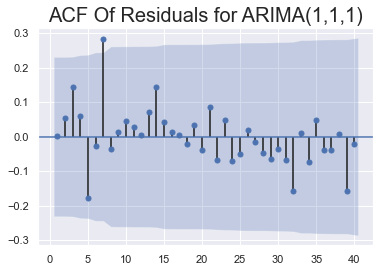

In [14]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40) # prendo gli elementi che partono da quello con indice 1
plt.title("ACF Of Residuals for ARIMA(1,1,1)",size=20)
plt.show()

## Higher-Lag ARIMA Models

In [ ]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

In [ ]:
print("ARIMA(1,1,1):  \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

In [ ]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_2, results_ar_1_i_1_ma_3)))

In [ ]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_1, results_ar_1_i_1_ma_3, DF = 2)))

In [ ]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

In [ ]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit(start_ar_lags=11)
model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit(start_ar_lags=11)

In [ ]:
results_ar_5_i_1_ma_1.summary()

In [ ]:
print("ARIMA(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5,1,1):  \t LL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(6,1,3):  \t LL = ", results_ar_6_i_1_ma_3.llf, "\t AIC = ", results_ar_6_i_1_ma_3.aic)

In [ ]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_1_i_1_ma_3, results_ar_6_i_1_ma_3, DF = 5)))

In [ ]:
print("\nLLR test p-value = " + str(LLR_test(results_ar_5_i_1_ma_1, results_ar_6_i_1_ma_3, DF = 3)))

In [ ]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,1,1)", size=20)
plt.show()

## Models with Higher Levels of Integration

In [ ]:
df['delta_prices']=df.market_value.diff(1)

In [ ]:
model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
results_delta_ar_1_i_1_ma_1.summary()

In [ ]:
sts.adfuller(df.delta_prices[1:])

In [ ]:
model_ar_1_i_2_ma_1 = ARIMA(df.market_value, order=(1,2,1))
results_ar_1_i_2_ma_1 = model_ar_1_i_2_ma_1.fit(start_ar_lags=10)
results_ar_1_i_2_ma_1.summary()

In [ ]:
df['res_ar_1_i_2_ma_1'] = results_ar_1_i_2_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_2_ma_1[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,2,1)",size=20)
plt.show()

## ARIMAX 

In [ ]:
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog = df.spx, order=(1,1,1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
results_ar_1_i_1_ma_1_Xspx.summary()

## SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model_sarimax = SARIMAX(df.market_value, exog = df.spx, order=(1,0,1), seasonal_order = (2,0,1,5))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()